---
# Introduction à l'apprentissage automatique
---

<center><img src="./img/mlprocess_3.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

# Exemple 3 : Pipeline d'analyse des données

Dans cet exercice, l'objectif est de comprendre la notion de pipeline d'analyse des données. C'est un des outils les plus 
utiles de Scikit-Learn, rien de moins. Nous allons apprendre ce qu'ils sont, à quoi ils servent, comment en 
construire un et comment l'optimiser pour une tâche donnée. Un pipeline simplifie considérablement la tâche des programmeurs.


Import des librairies nécessaires

In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import (manifold, datasets, decomposition, discriminant_analysis)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

## Pour le générateur de nombres pseudo-aléatoires et la reproductibilité des résultats
rng_seed = 0 


Automatically created module for IPython interactive environment


### Qu'est-ce qu'un pipeline de traîtement de données?

On a vu dans les modules précédents les différentes étapes de l'imputation de données manquantes, de leur 
standardisation, de leur redimensionnement, et enfin des exemples de classification (brièvement).
Dans chaque cas, on étudiait l'étape séparément, hors d'un contexte global, afin d'apprendre à l'utiliser 
dans des situations précises. 
Lorsqu'on finit par maîtriser chaque étape d'un projet en apprentissage machine, il devient intéressant de pouvoir 
les combiner afin d'élaborer un processus complet d'analyse qui combine les forces de chacune.  

C'est bien ce que permet de faire un pipeline d'analyse des données. La majorité des projets 
(allant au delà de l'exploration des données) devraient éventuellement passer par cette étape. Elle est efficace en 
 termes de gestion et de développement d'un projet complexe. Idéalement on devrait ne modifier que quelques sections
 d'un pipeline lorsqu'on veut tester une nouvelle idée ou implémenter un nouvel algorithme d'analyse. Pas besoin 
 de recommencer un nouveau programme à chaque fois; la roue une fois inventée, n'a besoin que d'être poussée dans une nouvelle direction. 
 
Nous allons présenter quatre exemples incrémentaux de pipelines. Rien de bien complexe, mais suffisamment instructifs pour 
vous donner des idées. Apprennez à les utiliser; ils pourraient déjà vous simplifier la vie dans vos exercices    


#### Exemples de données

Nous allons utiliser à nouveau un sous-ensemble de la base de données MNIST qui comprend des images de chiffres 0 à 9 
de taille 8x8. On peut considérer qu'à chaque image correspond un point dans un espace de dimension 8*8=64. Nous n'allons 
utiliser que les images des classes 0 à 5.

In [2]:
# Lecture de la base de données Digits en ne sélectionnant que les images des classes 0 à 5.
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30
n_components = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng_seed)

Text(0.5, 1.0, 'Une sélection des 6 premiers chiffres de la base de données MNIST')

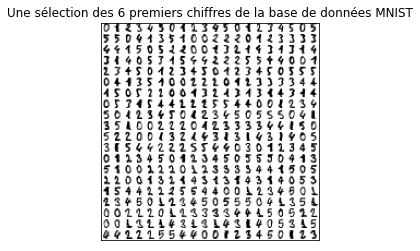

In [3]:
# Affichons quelques images de chiffres pour l'exemple
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('Une sélection des 6 premiers chiffres de la base de données MNIST')

### Pipeline #1

Comme premier essai, construisons un pipeline de base combinant deux étapes de prétraîtement, suivie d'une étape 
de classification. 

Nous allons effectuer les étapes suivantes:

<ol>
<li>Standardisation</li>
<li>Redimensionnement avec la méthode PCA </li>
<li>Classification avec la méthode SVM (RBF)</li>
</ol>

Chaque opération utilisera ses paramètres par défaut ou ceux spécifiés dans l'appel de la fonction.
N.B. Les noms (transformation, reduce_dim, classify) utilisés dans la définition du pipeline sont arbitraires. Vous 
pouvez les changer, mais faites en sorte qu'ils signifient quelque chose de plus utile que testA, Bozo, Zop, etc.   


In [4]:
# Définition du pipeline
pipeline = Pipeline([('transformation', StandardScaler()), 
                     ('reduce_dim', decomposition.PCA(n_components=2)),
                     ('classify', SVC(kernel='rbf', C=1, gamma=.2, max_iter=1000))])                     

# Entraînement 
pipeline.fit(X_train, y_train)

# Évaluation de ses performances sur l'ensemble de test.
pipeline.score(X_test, y_test)

# Plutôt simple non?

0.7896678966789668

### Pipeline #2

Supposons maintenant qu'on ne soit pas certain que la standardisation soit la meilleure méthode de 
transformation des données. On aimerait en tester au moins deux:
    
<ol>
<li>Standardisation</li>
<li>QuantileTransformer </li>
</ol>

De plus, on voudrait garder inchangées les étapes de redimensionnement et de classification. On 
procède en utilisant le mot-clé *passthrough* qui permet de spécifier chacun des choix à essayer 
pour l'étape de transformation des données.

In [5]:
# Définition du pipeline avec mot clé passthrough
pipeline = Pipeline([('transformation', 'passthrough'), 
                     ('reduce_dim', decomposition.PCA(n_components=2)),
                     ('classify', SVC(kernel='rbf', C=1, gamma=.2, max_iter=1000))])             

# Grille des paramètres à modifier. le mot clé passthrough renvoie ici
param_grid = [
    {
            'transformation': [StandardScaler()]
    },                 
    {
            'transformation': [QuantileTransformer(output_distribution='normal', n_quantiles=50)]
    }
]
           

Il faut maintenant tester les deux pipelines afin de trouver le plus performant des deux. Pour 
cela, on utilisera la fonction GridSearchCV qui permet d'effectuer une recherche sur une grille 
de paramètres/hyperparamètres qui sont dans ce cas-ci les deux méthodes de transformation. GridSearchCV procède 
par validation croisée sur l'ensemble d'entraînement. La combinaison des fonctions Pipeline et 
GridSearchCV est un des joyaux de Scikit-Learn. Il faut apprendre à l'utiliser afin d'en profiter au mieux.

In [6]:
# Définition de la recherche sur grille. L'affichage indique que 10 fits ont été effectués. 
# Il y avait 2 modèles à tester et 5 repliements pour chacun d'entre eux lors de la validation croisée.
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, verbose=1, refit=True)

# Entraînement du pipeline avec chaque combinaison de paramètres.
grid_search.fit(X_train, y_train) 


Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('transformation', 'passthrough'),
                                       ('reduce_dim', PCA(n_components=2)),
                                       ('classify',
                                        SVC(C=1, gamma=0.2, max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'transformation': [StandardScaler()]},
                         {'transformation': [QuantileTransformer(n_quantiles=50,
                                                                 output_distribution='normal')]}],
             verbose=1)

Définissons une fonction affichant les paramètres du pipeline optimal:

In [7]:
def afficheMeilleurChoixParametres(grid_search):
    print("\nMeilleur score en entraînement: %0.3f" % grid_search.best_score_)

    print("\nMeilleur choix de paramètres:")
    best_parameters = grid_search.best_estimator_.get_params()
    steps = dict(grid_search.best_estimator_.steps)

    for param_name in sorted(steps.keys()):
        print("\t%s: %r" % (param_name, steps[param_name]))

    print("\nScore en test: %0.3f" % grid_search.score(X_test, y_test))


Quels sont les paramètres du pipeline optimal?

In [9]:
afficheMeilleurChoixParametres(grid_search)


Meilleur score en entraînement: 0.818

Meilleur choix de paramètres:
	classify: SVC(C=1, gamma=0.2, max_iter=1000)
	reduce_dim: PCA(n_components=2)
	transformation: StandardScaler()

Score en test: 0.790


GridSearchCV a choisi la standardisation comme transformation de données. Une fois trouvés les 
meilleurs paramètres, on génère le pipeline et on l'entraîne avec *toutes* les données d'entraînement.

In [10]:
# Pipeline optimal
pipeline = Pipeline([('transformation', StandardScaler()), 
                     ('reduce_dim', decomposition.PCA(n_components=2)),
                     ('classify', SVC(kernel='rbf', C=1, gamma=.2, max_iter=1000))]) 

# Entraînement
pipeline.fit(X_train, y_train)

# Si l'on désire traiter un nouvel ensemble de données X_new, il ne reste plus qu'à faire ceci:
# y_pred = pipeline.predict(X_new)

# Plutôt simple non?

Pipeline(steps=[('transformation', StandardScaler()),
                ('reduce_dim', PCA(n_components=2)),
                ('classify', SVC(C=1, gamma=0.2, max_iter=1000))])

### Pipeline #3

Se pourrait-il que le choix de la standardisation ait été influencé par les valeurs 
des paramètres des deux autres opérations? C'est très pertinent comme question. On va le vérifier.

On va optimiser à nouveau le pipeline en faisant varier les facteurs suivants:
    
<ol>
<li>Transformation: 
    <blockquote> 
    <ul>Standardisation</ul>
    <ul>QuantileTransformer </ul>
    </blockquote> 
<li>Réduction de la dimensionalité:
    <blockquote> 
    <ul>n_components = [2, 4, 8, 16, 32]</ul>
    </blockquote> 
<li>Classificateur SVM (RBF):  
    <blockquote> 
    <ul>C = [0.1, 1, 10, 100, 1000]</ul>
    <ul>gamma = [1, 0.1, 0.01, 0.001, 0.0001]</ul>
    </blockquote> 
</ol>


In [11]:
# Définition du pipeline
pipeline = Pipeline([('transformation', 'passthrough'), 
                     ('reduce_dim', decomposition.PCA()),
                     ('classify', SVC(kernel='rbf', max_iter=1000))])             

param_grid = [
        {
        'transformation': [StandardScaler()],
        'reduce_dim__n_components': [2, 4, 8, 16, 32], 
        'classify__C': [0.1, 1, 10, 100, 1000],  
        'classify__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
        },                 
        {
        'transformation': [QuantileTransformer(output_distribution='normal', n_quantiles=50)],
        'reduce_dim__n_components': [2, 4, 8, 16, 32], 
        'classify__C': [0.1, 1, 10, 100, 1000],  
        'classify__gamma': [1, 0.1, 0.01, 0.001, 0.0001]     
        }
]
                 

In [12]:
# Définition de la recherche sur grille. 
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, verbose=1, refit=True)

# Entraînement du pipeline avec chaque combinaison de paramètres.
grid_search.fit(X_train, y_train) 


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(estimator=Pipeline(steps=[('transformation', 'passthrough'),
                                       ('reduce_dim', PCA()),
                                       ('classify', SVC(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'classify__C': [0.1, 1, 10, 100, 1000],
                          'classify__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'reduce_dim__n_components': [2, 4, 8, 16, 32],
                          'transformation': [StandardScaler()]},
                         {'classify__C': [0.1, 1, 10, 100, 1000],
                          'classify__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'reduce_dim__n_components': [2, 4, 8, 16, 32],
                          'transformation': [QuantileTransformer(n_quantiles=50,
                                                                 output_distribution='normal')]}],
             verbose=1)

In [13]:
afficheMeilleurChoixParametres(grid_search)


Meilleur score en entraînement: 0.995

Meilleur choix de paramètres:
	classify: SVC(C=10, gamma=0.01, max_iter=1000)
	reduce_dim: PCA(n_components=16)
	transformation: QuantileTransformer(n_quantiles=50, output_distribution='normal')

Score en test: 0.978


La méthode de transformation a changé; le QuantileTransformer 
est maintenant préféré. De plus, le score en test est passé de 79% à 97.8%!

### Pipeline #4

Dans ce dernier exemple, nous utiliserons la standardisation comme méthode de transformation de données. 
Nous allons optimiser la méthode de réduction de la dimensionalité et les paramètres de la fonction SVM. 

Les données en 64D seront réduites en 2D ou en 3D (n_components = [2, 3]). 

On va optimiser le pipeline en faisant varier les facteurs suivants:
    
<ol>
<li>Réduction de la dimensionalité:
    <blockquote> 
    <ul>Méthodes:</ul>   
    <blockquote> 
    <ul>PCA</ul>
    <ul>LinearDiscriminantAnalysis</ul>
    <ul>Isomap</ul>
    </blockquote> 
    <ul>n_components = [2, 3]</ul>
    </blockquote> 
<li>Classificateur SVM (RBF):  
    <blockquote> 
    <ul>C = [0.1, 1, 10, 100, 1000]</ul>
    <ul>gamma = [1, 0.1, 0.01, 0.001]</ul>
    </blockquote> 
</ol>


In [14]:
# Définition du pipeline
pipeline = Pipeline([('transformation', StandardScaler()),
                     ('reduce_dim', 'passthrough'),
                     ('classify', SVC(kernel='rbf', max_iter=1000))])            

param_grid = [
    {
        'reduce_dim':  [decomposition.PCA()],   
        'reduce_dim__n_components': [2, 3], 
        'classify__C': [1, 10, 100, 1000],  
        'classify__gamma': [1, 0.1, 0.01, 0.001], 
    },                  
    {
        'reduce_dim':  [discriminant_analysis.LinearDiscriminantAnalysis()],   
        'reduce_dim__n_components': [2, 3], 
        'classify__C': [1, 10, 100, 1000],  
        'classify__gamma': [1, 0.1, 0.01, 0.001], 
    },              
    {
        'reduce_dim':  [manifold.Isomap()],   
        'reduce_dim__n_components': [2, 3], 
        'classify__C': [1, 10, 100, 1000],  
        'classify__gamma': [1, 0.1, 0.01, 0.001], 
    }              
]
            

In [15]:
# Définition de la recherche sur grille.  
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, verbose=1, refit=True)

# Entraînement du pipeline avec chaque combinaison de paramètres.
grid_search.fit(X_train, y_train) 


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=Pipeline(steps=[('transformation', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', SVC(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'classify__gamma': [1, 0.1, 0.01, 0.001],
                          'reduce_dim': [PCA()],
                          'reduce_dim__n_components': [2, 3]},
                         {'classify__C': [1, 10, 100, 1000],
                          'classify__gamma': [1, 0.1, 0.01, 0.001],
                          'reduce_dim': [LinearDiscriminantAnalysis()],
                          'reduce_dim__n_components': [2, 3]},
                         {'classify__C': [1, 10, 100, 1000],
                          'classify__gamma': [1, 0.1, 0.01, 0.001],
                          'reduce_dim': [Isomap(n_components=3)],
                          'reduce_dim__n_components': 

In [16]:
afficheMeilleurChoixParametres(grid_search)

grid_predictions = grid_search.predict(X_test)
print('\n')
print(classification_report(y_test, grid_predictions))


Meilleur score en entraînement: 0.983

Meilleur choix de paramètres:
	classify: SVC(C=10, gamma=0.01, max_iter=1000)
	reduce_dim: Isomap(n_components=3)
	transformation: StandardScaler()

Score en test: 0.974


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.97      1.00      0.99        38
           2       0.98      0.98      0.98        45
           3       0.88      0.97      0.92        37
           4       1.00      0.98      0.99        50
           5       1.00      0.92      0.96        52

    accuracy                           0.97       271
   macro avg       0.97      0.98      0.97       271
weighted avg       0.98      0.97      0.97       271



Le pipeline #4 est aussi performant que le précédent, mais il travaille maintenant dans un espace 3D plutôt 
qu'en 16D!

À vous d'expérimenter avec d'autres méthodes (transformation des données, réduction de la dimensionalité, classification) 
et paramètres.

Vous pourriez même inclure une étape d'imputation de données avant celle de la transformation!

N.B. Il arrive souvent que les paramètres ou méthodes que l'on essaie ne mènent pas à une solution viable. Dans ce cas, 
des avertissements (warnings) sont affichés. Ils indiquent que certains modèles n'ont pû être entrainés correctement. 
Néanmoins, la solution finale affichée correspond au meilleur entraînement complété.


## La modération a bien meilleur goût!

Bien qu'il soit pratique de nettoyer ses données puis de les classifier dans un même pipeline, ce 
n'est généralement pas la meilleure stratégie. 

Vous devriez plutôt utiliser un pipeline pour trouver la bonne méthode de prétraîtement puis l'implémenter. 
Ça vous permettrait de vous concentrer ensuite sur ce qui est la partie la plus intéressante d'un projet; la 
classification, la régression, etc. Créez un second pipeline pour traiter cette nouvelle partie 
d'un projet. Inutile de refaire le prétraîtement des données à chaque fois. 
